**Implementação do Modelo de Classificação Binária:**

---



**Nota 1:** No trecho de código a seguir são importadas as funções e bibliotecas necessárias, definidas as funções de ativação e de perda, bem como definidas a classe que estrutura a rede neural e as funções utilizadas para realizar a propagação para frente, a retropropagação, o treinamento da rede e as previsões utilizando o conjunto de teste:

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt


# Função de ativação: Sinal
def sinal(x):
    u = x.item(0)
    if x > 0:
        return 1;
    return -1;


# Função de ativação: Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Derivada da função Sigmoid
def derivada_sigmoid(x):
    return x * (1 - x)


# Função de ativação: ReLU
def relu(x):
    return np.maximum(0, x)


# Derivada de ReLU
def derivada_relu(x):
    return np.where(x > 0, 1, 0)


# Função de perda: Entropia Cruzada Binária: calcula a diferença entre os valores reais e previstos no contexto de classificação binária.
def entropia_cruzada_binaria(y_verdadeiro, y_predito):

    y_predito = np.clip(y_predito, 1e-15, 1 - 1e-15)  # Evitar valores fora da faixa (0, 1)
    return -np.mean(y_verdadeiro * np.log(y_predito) + (1 - y_verdadeiro) * np.log(1 - y_predito))


# Função de perda: Erro Quadrático Médio (EQM)
def eqm(y_verdadeiro, y_predito):
    return np.mean((y_verdadeiro - y_predito) ** 2)


# Estrutura da Rede Neural
class ClassificacaoBinaria:

    def __init__(self, entrada_tamanho, oculto_tamanho, saida_tamanho, taxa_aprendizado):

        # Número de atributos (colunas de entrada).
        self.entrada_tamanho = entrada_tamanho
        # Número de neurônios na camada oculta.
        self.oculto_tamanho = oculto_tamanho
        # Número de classes ou saídas (1 neste caso para classificação binária).
        self.saida_tamanho = saida_tamanho
        # Taxa para o gradiente descendente.
        self.taxa_aprendizado = taxa_aprendizado

        # Inicialização dos pesos e vieses com valores aleatórios pequenos
        self.pesos_entrada_oculto = np.random.randn(entrada_tamanho, oculto_tamanho) * 0.01
        self.vies_oculto = np.zeros((1, oculto_tamanho))
        self.pesos_oculto_saida = np.random.randn(oculto_tamanho, saida_tamanho) * 0.01
        self.vies_saida = np.zeros((1, saida_tamanho))


    # Calcula a saída da rede. Recebe como parâmetro o conjunto de dados de entrada.
    def propagacao_frente(self, entrada):

        # CAMADA 1: Propagação da camada de entrada para a oculta
        self.entrada_oculto = np.dot( entrada, self.pesos_entrada_oculto ) + self.vies_oculto
        self.saida_oculto = sigmoid( self.entrada_oculto )

        # CAMADA 2: Propagação da camada oculta para a camada de saída
        self.entrada_saida = np.dot( self.saida_oculto, self.pesos_oculto_saida ) + self.vies_saida
        self.saida_final = sigmoid( self.entrada_saida )

        return self.saida_final


    # Executa retropropagação (backpropagation) para atualizar os pesos.
    # - entrada: dados de entrada.
    # - y_verdadeiro: valores reais
    # - saida: saída gerada pela rede.
    def retropropagacao(self, entrada, y_verdadeiro, saida):

        # Calcula o erro da saída
        erro = y_verdadeiro - saida

        # Calcula o gradiente na camada de saída
        gradiente_saida = erro * derivada_sigmoid(saida)

        # Calcula o erro e o gradiente na camada oculta
        erro_oculto = np.dot( gradiente_saida, self.pesos_oculto_saida.T )
        gradiente_oculto = erro_oculto * derivada_sigmoid(self.saida_oculto)

        # Atualização dos pesos e vieses entre a camada oculta e a saída
        gradiente_pesos_saida = np.dot( self.saida_oculto.T, gradiente_saida )  # Matriz de ajustes para pesos
        gradiente_vies_saida = np.sum( gradiente_saida, axis=0, keepdims=True )  # Vetor de ajustes para vieses
        self.pesos_oculto_saida += gradiente_pesos_saida * self.taxa_aprendizado
        self.vies_saida += gradiente_vies_saida * self.taxa_aprendizado

        # Atualização dos pesos e vieses entre a camada de entrada e a oculta
        gradiente_pesos_oculto = np.dot (entrada.T, gradiente_oculto )  # Matriz de ajustes para pesos
        gradiente_vies_oculto = np.sum( gradiente_oculto, axis=0, keepdims=True )  # Vetor de ajustes para vieses
        self.pesos_entrada_oculto += gradiente_pesos_oculto * self.taxa_aprendizado
        self.vies_oculto += gradiente_vies_oculto * self.taxa_aprendizado


    # Treina a rede neural por um número determinado de épocas.
    def treinar(self, entrada, y_verdadeiro, epocas):
        print()
        perdas = []
        for epoca in range(epocas):
            saida = self.propagacao_frente(entrada)
            # Calcula a perda (erro) da rede usando a função de perda de entropia cruzada binária
            perda = entropia_cruzada_binaria(y_verdadeiro, saida)
            # Calcula a perda (erro) da rede usando a função de perda de erro quadrático médio
            # perda = eqm(y_verdadeiro, saida)
            perdas.append(perda)
            self.retropropagacao(entrada, y_verdadeiro, saida)
            if epoca % 200 == 0:
                print("Época " + str(epoca) + ", Perda: " + "{:.4f}".format(perda))
        return perdas


    # Realiza previsões para o conjunto de entrada.
    def prever(self, entrada):
        saida = self.propagacao_frente(entrada)
        return np.round(saida)


**Nota 2:** A seguir é realizado o carregamento do conjunto de dados utilizado, o qual foi obtido em https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability. Esse conjunto contém medições de qualidade da água e avaliações relacionadas à potabilidade. Colunas disponíveis:

   1. pH: nível de pH da água.
   2. Hardness: dureza da água, uma medida do conteúdo mineral.
   3. Solids: total de sólidos dissolvidos na água.
   4. Chloramines: concentração de cloraminas na água.
   5. Sulfate: concentração de sulfato na água.
   6. Conductivity: condutividade elétrica da água.
   7. Organic carbon: conteúdo de carbono orgânico na água.
   8. Trihalomethanes: concentração de trihalometanos na água.
   9. Turbidity: nível de turbidez, uma medida da clareza da água.
   10. Potability: variável alvo; indica potabilidade da água com valores 1 (potável) e 0 (não potável).

In [2]:
# Carregamento do conjunto de dados
print("Por favor, faça o upload do arquivo 'water_potability.csv'")
arquivo = files.upload()
dados = pd.read_csv("water_potability.csv")

# Fonte: https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability
#:: Variáveis independentes:
#   1. pH: nível de pH da água.
#   2. Hardness: dureza da água, uma medida do conteúdo mineral.
#   3. Solids: total de sólidos dissolvidos na água.
#   4. Chloramines: concentração de cloraminas na água.
#   5. Sulfate: concentração de sulfato na água.
#   6. Conductivity: condutividade elétrica da água.
#   7. Organic carbon: conteúdo de carbono orgânico na água.
#   8. Trihalomethanes: concentração de trihalometanos na água.
#   9. Turbidity: nível de turbidez, uma medida da clareza da água.
#:: Variável dependente:
#   10. Potability: variável alvo; indica potabilidade da água com valores 1 (potável) e 0 (não potável).

Por favor, faça o upload do arquivo 'water_potability.csv'


Saving water_potability.csv to water_potability.csv


**Nota 3:** Vários registros desse conjunto possuiam valores de variáveis vazios. Foi decidido, então, remover as linhas com valores nulos.

In [3]:
# Configurações para evitar quebras de linha ao exibir matrizes (arrays)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
np.set_printoptions(linewidth=np.inf)

print("\nTamanho original do conjunto de dados (linhas, colunas): ", dados.shape)

# Remove linhas com valores nulos
dados.dropna(inplace=True)

print("\nTamanho após remoção de linhas com valores nulos (linhas, colunas): ", dados.shape)

# Primeiros 10 registros do conjunto de dados
print("\n Primeiros 10 registros (matriz 10x10) do conjunto de dados:\n", dados.head(10))


Tamanho original do conjunto de dados (linhas, colunas):  (3276, 10)

Tamanho após remoção de linhas com valores nulos (linhas, colunas):  (2011, 10)

 Primeiros 10 registros (matriz 10x10) do conjunto de dados:
            ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability
3    8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516       18.436524       100.341674   4.628771           0
4    9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813       11.558279        31.997993   4.075075           0
5    5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916        8.399735        54.917862   2.559708           0
6   10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634       13.789695        84.603556   2.672989           0
7    8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645       12.363817        62.798309

In [4]:
# Separa o conjunto entre variáveis de entrada/independentes (X) e variável alvo/dependente (y)
X = dados.drop(columns="Potability").values
y = dados["Potability"].values.reshape(-1, 1)

# Normalização dos dados para trazer todas as variáveis para a mesma escala
normalizador = StandardScaler()
X = normalizador.fit_transform(X)

# Divisão dos dados entre treino e teste na proporção de 85/15
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=777)

print("\nPrimeiras 10 linhas de X_treino (conjunto de TREINO), de um total de ", X_treino.shape[0], " linhas, seguidas pelo vetor de variáveis dependentes (y_treino):")
print(X_treino[:10])
print(y_treino[:10])

print("\nPrimeiras 10 linhas de X_teste (conjunto de TESTE), de um total de ", X_teste.shape[0], " linhas, seguidas pelo vetor de variáveis dependentes (y_teste):")
print(X_teste[:10])
print(y_teste[:10])


Primeiras 10 linhas de X_treino (conjunto de TREINO), de um total de  1709  linhas, seguidas pelo vetor de variáveis dependentes (y_treino):
[[ 1.49275106e+00 -1.15181496e+00 -1.66968216e-01 -8.05973552e-01 -1.16105464e+00  6.23547427e-01  9.21749859e-03  4.20821948e-01  2.96513411e-01]
 [-1.66604441e-01 -1.52749315e+00 -9.77948240e-01 -4.48814989e-01 -1.05955312e+00 -1.69605625e-01 -1.50483580e-02  9.41241160e-01  5.94951618e-02]
 [ 6.39390357e-03  7.82793302e-01 -5.41362402e-01  1.29203559e+00 -2.57502433e-01  1.98496642e-01  6.67389555e-01  7.29244683e-01  1.04583268e+00]
 [-1.65860684e+00  1.23561639e+00  5.70136252e-01 -1.44637894e+00 -3.04246669e+00  3.77400159e-01  5.61950175e-01  4.75006708e-01  4.58822688e-01]
 [ 1.30309947e+00 -3.53221023e-02 -1.43754635e+00 -5.98584862e-01  3.03181366e-01  1.68844756e+00 -2.04947942e-01  4.99175719e-01 -8.81785219e-01]
 [ 6.06878896e-02  4.18596310e-01 -7.77909809e-01 -7.19288825e-01  1.24087108e-01 -1.04613341e+00 -1.93587720e+00  3.196079


Época 0, Perda: 0.6947
Época 200, Perda: 0.6716
Época 400, Perda: 0.6602
Época 600, Perda: 0.6389
Época 800, Perda: 0.6386
Época 1000, Perda: 0.6380
Época 1200, Perda: 0.6374
Época 1400, Perda: 0.6320
Época 1600, Perda: 0.5816
Época 1800, Perda: 0.5864
Época 2000, Perda: 0.5794
Época 2200, Perda: 0.5753
Época 2400, Perda: 0.5719
Época 2600, Perda: 0.5664
Época 2800, Perda: 0.5626
Época 3000, Perda: 0.5604
Época 3200, Perda: 0.5575
Época 3400, Perda: 0.5546
Época 3600, Perda: 0.5532
Época 3800, Perda: 0.5516
Época 4000, Perda: 0.5505
Época 4200, Perda: 0.5499
Época 4400, Perda: 0.5498
Época 4600, Perda: 0.5508
Época 4800, Perda: 0.5517
Época 5000, Perda: 0.5508

:: Métricas de Avaliação do Modelo:
 - Acurácia: 0.6987
 - Precisão: 0.6581
 - Recall: 0.6016
 - F1-Score: 0.6286


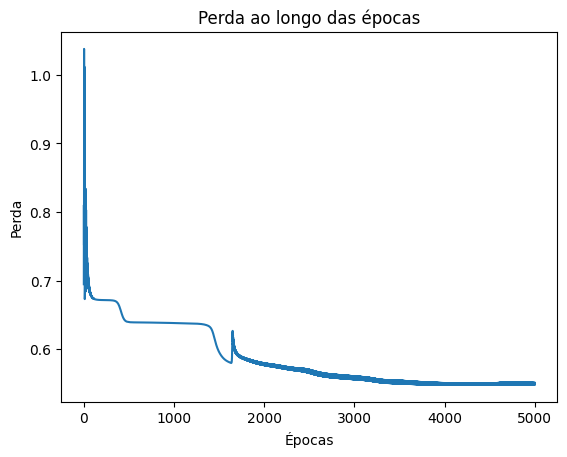

In [5]:
# Criação da Rede Neural de Classificação Binária: entrada_tamanho, oculto_tamanho, saida_tamanho, taxa_aprendizado=0.01:
rede_Class_Binaria = ClassificacaoBinaria(X_treino.shape[1], 10, 1, 0.01)

# Treinamento da Rede Neural
perdas = rede_Class_Binaria.treinar(X_treino, y_treino, epocas=5001)

# Avaliação da Rede Neural
y_predito = rede_Class_Binaria.prever(X_teste)

# Calcula o total de previsões corretas
previsoes_corretas = 0
for yreal, ypred in zip(y_teste, y_predito):
    if yreal == ypred:
        previsoes_corretas += 1

print("\n:: Métricas de Avaliação do Modelo:")
# Acurácia
acuracia = previsoes_corretas / len(y_teste)
print(" - Acurácia: {:.4f}".format(acuracia))

# Precisão
vp = np.sum((y_teste == 1) & (y_predito == 1))  # Verdadeiros positivos
fp = np.sum((y_teste == 0) & (y_predito == 1))  # Falsos positivos
precisao = vp / (vp + fp) if (vp + fp) != 0 else 0
print(" - Precisão: {:.4f}".format(precisao))

# Recall
vp = np.sum((y_teste == 1) & (y_predito == 1))  # Verdadeiros positivos
fn = np.sum((y_teste == 1) & (y_predito == 0))  # Falsos negativos
recall = vp / (vp + fn) if (vp + fn) != 0 else 0
print(" - Recall: {:.4f}".format(recall))

# F1-Score
f1_score = 2 * (precisao * recall) / (precisao + recall) if (precisao + recall) != 0 else 0
print(" - F1-Score: {:.4f}".format(f1_score))

# Exibe a curva de perda
plt.plot(perdas)
plt.title("Perda ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.show()
print()